In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns

import pathlib
import os
from tqdm import tqdm
import pandas as pd
import json

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageDraw
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import skimage.io
import matplotlib
from selective_search import selective_search, box_filter
from collections import Counter
from tqdm import tqdm

print(tf.__version__)

2.10.0


# Data preps

In [2]:
flowers_dir = './Flowers/'
flower_labels = sorted(os.listdir(flowers_dir))
print(flower_labels)
inverse_flower_label = {v: k for k, v in enumerate(flower_labels)}
print(inverse_flower_label)

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
{'Babi': 0, 'Calimerio': 1, 'Chrysanthemum': 2, 'Hydrangeas': 3, 'Lisianthus': 4, 'Pingpong': 5, 'Rosy': 6, 'Tana': 7}


In [3]:
def get_coco_cordinate(cord1, cord2):
    x1, y1 = cord1
    x2, y2 = cord2
    x = min(x1, x2)
    y = min(y1, y2)
    return (min(x1, x2), min(y1, y2), max(x2 , x1), max(y2 ,y1))

def COCO_format(meta_dir):
    result = []
    images = []
    meta_data_label = sorted(os.listdir(meta_dir))
    counter = 0
    for file in meta_data_label:
        f = open(meta_dir + "/" + file)
        meta_data_ = json.load(f)
        each_file = {}
        try:
            flower_name = meta_data_['imagePath'].split('\\')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('\\')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("\\")[-2:])

            each_file['path'] = file_path
            each_file['label'] = flower_name
            each_file['boxes'] = []
        except:
            flower_name = meta_data_['imagePath'].split('/')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('/')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("/")[-2:])

            each_file['path'] = file_path
            each_file['label'] = flower_name
            each_file['boxes'] = []
            
            
        
        source_img = Image.open(file_path).convert("RGB")
        draw = ImageDraw.Draw(source_img)
        if (len(meta_data_['shapes']) == 0):
            continue
        for k, i in enumerate(meta_data_['shapes']):
            points = i['points']
            counter += 1
            each_file['boxes'].append(get_coco_cordinate(points[0], points[1]))
            if abs(points[0][0] - points[1][0]) < 1 or abs(points[0][1] - points[1][1]) < 1:
                print(meta_data_['imagePath'], points[0][0] - points[1][0], points[0][1] - points[1][1])
                continue
        result.append(each_file)
            # print(flower_name, file_path, points)
    # print("Finised", counter, "images")
    return result


In [4]:
meta_data = []
for i in flower_labels:
    meta_data += COCO_format(f"./Meta/{i}")
print(len(meta_data))

..\..\Flowers\Babi\babi_512.jpg 0.0 -3.5502958579881607
..\Flowers\Hydrangeas\hydrangeas_109.jpg 8.0 0.0
..\Flowers\Hydrangeas\hydrangeas_112.jpg 0.0 -12.0
3950


In [5]:
meta_data[6]

{'path': './Flowers/Babi/babi_105.jpg',
 'label': 'Babi',
 'boxes': [(31.41076487252124,
   35.324362606232306,
   173.0538243626062,
   123.14305949008498)]}

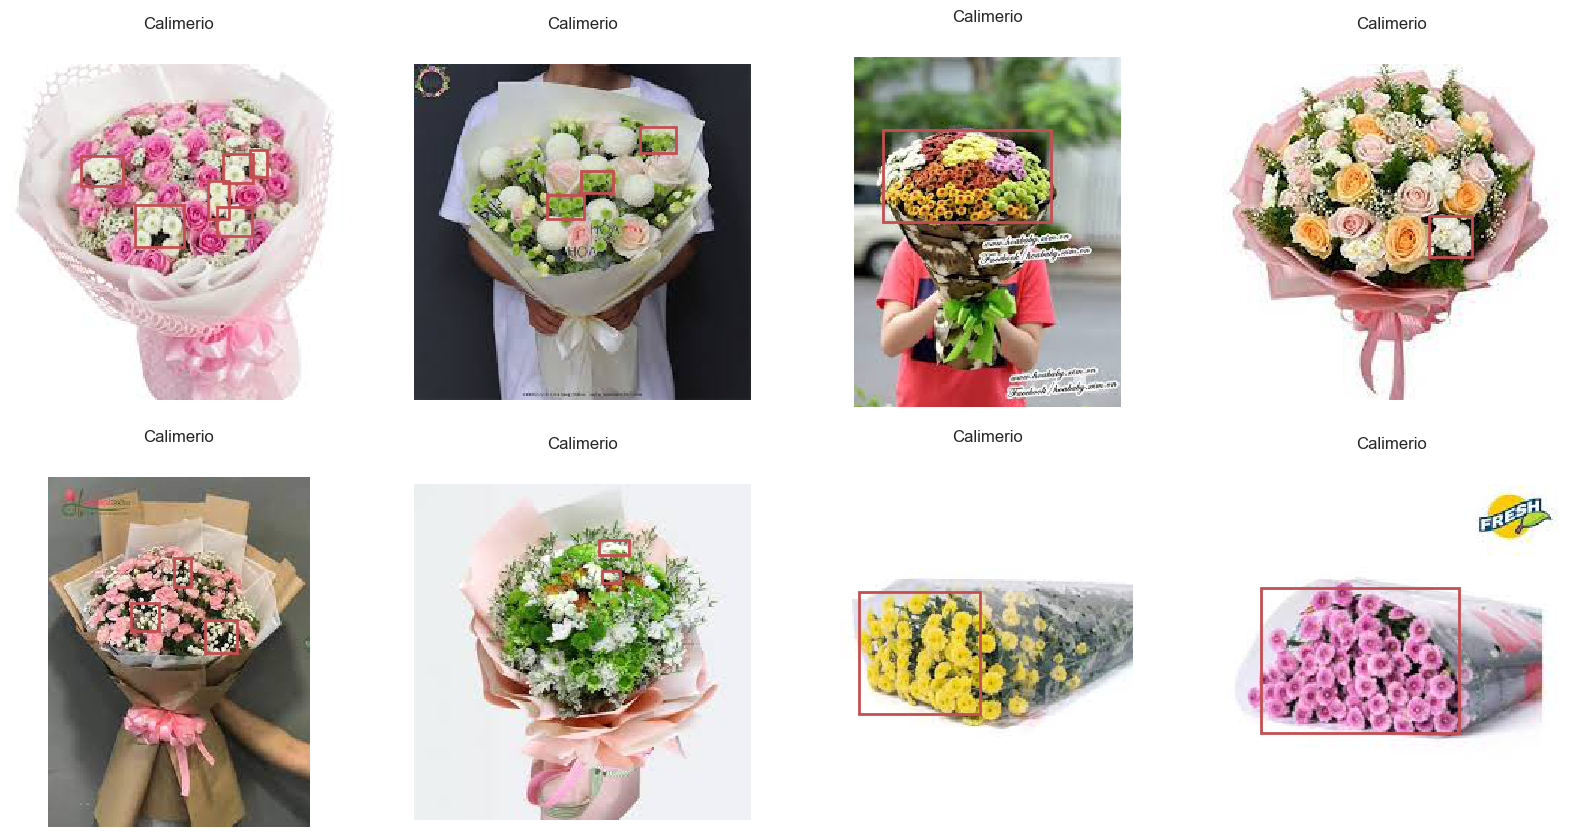

In [6]:
X = []
y = []
img_size = 256
img_height = 256
img_width = 256

fig,ax = plt.subplots(2, 4, figsize=(20,10))
ax=ax.flatten()
start_index = 800
flowers_dir_path_object = pathlib.Path(flowers_dir)

for k, meta in enumerate(meta_data):
    # flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    resized_image = np.array(load_img(meta['path']))
    
    
    if (k < 8 + start_index and k > start_index-1):
        ax[k - start_index].set_title(meta['label'])
        ax[k - start_index].axis('off')
        ax[k - start_index].matshow(resized_image)
        for z, (x1, y1, x2, y2) in enumerate(meta['boxes']):
            # meta['boxes'][k] = (x1, y1, x2, y2)
            rectangle = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax[k - start_index].add_patch(rectangle)


    X.append(np.array(resized_image))
    # for box in meta['boxes']:
    y.append({'label': inverse_flower_label[meta['label'].replace("PingPong", "Pingpong")],
             'boxes': meta['boxes']})
        


In [7]:
# def predict_with_selective(model, image_path):
    
#     # image = skimage.io.imread(image_path ,plugin='pil')#
#     image_r = load_img(image_path,target_size=(img_size, img_size))
#     image = np.asarray(image_r)
#     # print(image)
#     boxes = selective_search(image, mode='single', random_sort=False)
#     boxes_filter = box_filter(boxes, min_size=1, topN=20, max_ratio=16/9)
    
#     fix, ax = plt.subplots(figsize=(5,6))
#     ax.axis('off')
#     ax.matshow(image)
#     result = []
#     for k, (x1, y1, x2, y2) in enumerate(boxes_filter):
#         # boxes.append()
        
#         cropped_img = Image.open(path_).crop((x1, y1, x2, y2))
#         flower_pred_index, flower_pred_proba = predict_proba(model, cropped_img)
        
#         area = (x2 - x1) * (y2 - y1)
#         zone = {'area': area, 'prediction': flower_pred_index, 'proba': flower_pred_proba }
        
#         result.append((zone, (y1, x1, y2, x2), flower_pred_index, flower_pred_proba))
        
#     # print([i[1] for i in result][0])
    
#     nms = tf.image.non_max_suppression([i[1] for i in result], [i[3] for i in result], 10, iou_threshold=0.6)
#     nms_result_count = []
#     # for i in result:
        
#     for i in nms:
#         zone, boxes, flower_pred_index, flower_pred_proba = result[i]
#         nms_result_count.append(flower_pred_index)
#         x1, y1, x2, y2 = boxes
#         rect = matplotlib.patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=4, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#         area = (y2 - y1) * (x2 - x1)
#         print(boxes, area, f'{flower_pred_proba}%', flower_labels[flower_pred_index])
        
    
#     count_res = Counter(nms_result_count)
#     # print(max(count_res, key=count_res.get))
    
#     # for k, v in enumerate(flower_labels):
#     #     count = nms_result_count.count(k)
#     #     if (count > 0):
#     #         print(flower_labels[k], count)
#     return count_res.most_common(2)
#     # plt.show()

# selective_search_test_result = []
# for i in range(170, 185):
#     top_2 = predict_with_selective(model, f'./Flowers/Pingpong/pingpong_{i}.jpg')
#     selective_search_test_result.append(top_2[0][0])
    
    
# print(selective_search_test_result)

In [8]:
import os

def scanData():
    data_count = pd.DataFrame(data={"flower": [], "count": []})
    meta_data_df = pd.DataFrame(data={"image_path": [], "flower_type": []})
    folder_path = flowers_dir

    subdirectories = next(os.walk(folder_path))[1]

    print(subdirectories)

    for i in subdirectories:
        sub = next(os.walk(folder_path+"/"+i))
        
        new_meta_data = pd.DataFrame(data={"image_path": [ (sub[0] + "/" + j) for j in sub[2]] , "flower_type": i})
        meta_data_df = pd.concat([meta_data_df, new_meta_data], ignore_index=True)
        
        new_data = pd.DataFrame(data={"flower": i, "count": len(sub[2])}, index=[0])      
        data_count = pd.concat([data_count, new_data], ignore_index=True)
        print(i, len(sub[2]), len([ sub[0] + j for j in sub[2]]))

    return data_count, meta_data_df

img_count, meta_data = scanData()
img_count

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
Babi 933 933
Calimerio 353 353
Chrysanthemum 696 696
Hydrangeas 524 524
Lisianthus 969 969
Pingpong 360 360
Rosy 171 171
Tana 623 623


,flower,count
0,Babi,933.0
1,Calimerio,353.0
2,Chrysanthemum,696.0
3,Hydrangeas,524.0
4,Lisianthus,969.0
5,Pingpong,360.0
6,Rosy,171.0
7,Tana,623.0


<Axes: xlabel='flower', ylabel='count'>

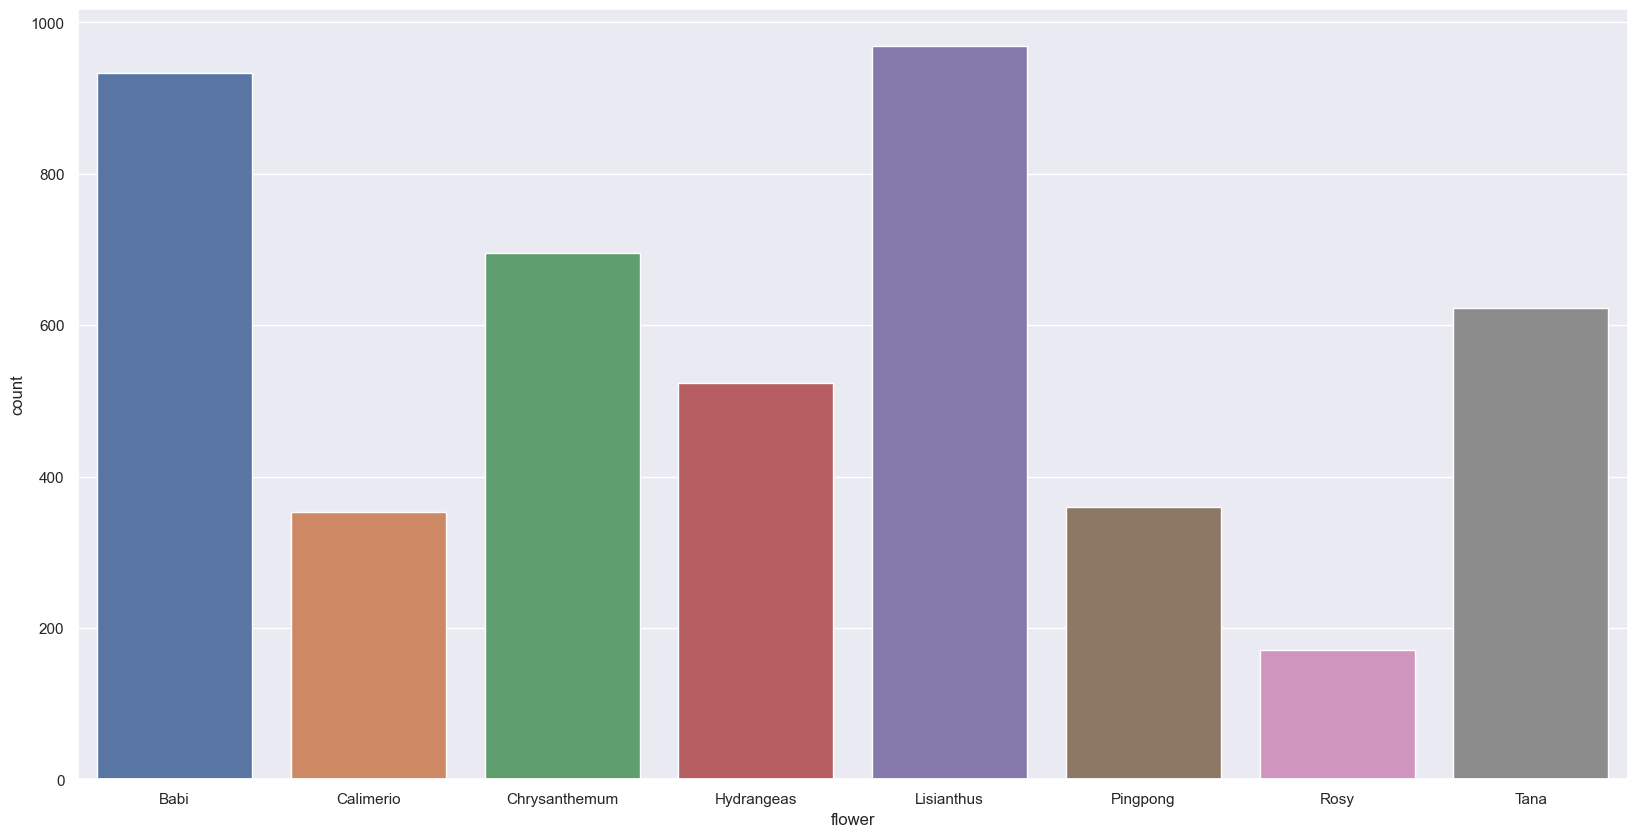

In [9]:
plt.figure(figsize=(20,10))
sns.barplot(data=img_count, x='flower', y='count')

In [10]:
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (3950,)
y shape: (3950,)


C:\Users\trann\AppData\Local\Temp\ipykernel_6272\3029746236.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


## Model Building

* Train test split
* Fine-tuning pre-trained model
* Model evaluation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (2962,)
X test shape: (988,)


# RCNN MODEL

In [12]:
from tensorflow.keras.layers import Conv2D, Layer
from tensorflow.keras.models import Model
# tf.compat.v1.enable_eager_execution() 
print(tf.executing_eagerly())

True


In [13]:
class SelectiveSearchLayer(Layer):
    def __init__(self):
        super(SelectiveSearchLayer, self).__init__()

    # def build(self, input_shape):
    #     self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), (None, 4)])

    def call(self, inputs):
        # print(tf.make_tensor_proto(inputs))
        # tf.make_ndarray(tf.make_tensor_proto(inputs)
        
        
        input_np =  inputs.numpy()# inputs.eval(session=tf.compat.v1.Session())
        boxes = selective_search(input_np, mode='single', random_sort=False)
        boxes_filter = box_filter(boxes, min_size=1, topN=20, max_ratio=16/9)
        boxes_np = []
        for (x1, y1, x2, y2) in boxes_filter:
            boxes_np.append(y1, x1, y2, x2)

        return inputs
        

In [14]:
class ROI_Pooling(Layer):
    def __init__(self, model_output):
        super(ROI_Pooling, self).__init__()
        self.model_output = model_output
        self.boxes = boxes
        
    def call(self, boxes):
        # print(self.model_output)
        ROIs = tf.image.crop_and_resize(
        self.model_output,
        np.array(self.boxes),
        [0],
        [256, 256],
        method='bilinear')
        return ROIs

In [16]:
def get_model():
    inputs = layers.Input(shape=(256, 256, 3))
    # rescale = tf.rescale()
    
    boxes_np = SelectiveSearchLayer()(inputs)
    
    resnet_backbone = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    # weights='imagenet',
    input_shape=(256,256,3),
    classes=9,
    classifier_activation='softmax',
    )
    
    
    model_output = resnet_backbone(inputs)
    ROI_Pooling(model_output)(boxes_np)
    
#     out_1 = Conv2D(16, (1, 1), activation='relu', kernel_initializer='lecun_uniform', dilation_rate=1, padding='same')(model_output)
#     out_6 = Conv2D(16, (2, 2), activation='relu', kernel_initializer='lecun_uniform',dilation_rate=6, padding='same')(model_output)
#     out_12 = Conv2D(16, (4, 4), activation='relu', kernel_initializer='lecun_uniform',dilation_rate=10, padding='same')(model_output)
#     out_14 = Conv2D(16, (8, 8), activation='relu', kernel_initializer='lecun_uniform',dilation_rate=14, padding='same')(model_output)
    
#     x = layers.Concatenate(axis=-1)([out_1, out_6, out_12, out_14])
#     x = layers.Flatten()(x)
    
#     x = layers.Dense(2048, activation='relu')(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dense(128, activation='relu')(x)

    #  nms_tf = tf.image.non_max_suppression(
    # boxes,
    # scores,
    # max_output_size,
    # iou_threshold=0.5,
    # name=None
    # )
    
    outputs = layers.Dense(8, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

my_model = get_model()

AttributeError: Exception encountered when calling layer "selective_search_layer_1" (type SelectiveSearchLayer).

in user code:

    File "C:\Users\trann\AppData\Local\Temp\ipykernel_6272\650534121.py", line 13, in call  *
        input_np =  inputs.numpy()# inputs.eval(session=tf.compat.v1.Session())

    AttributeError: 'Tensor' object has no attribute 'numpy'


Call arguments received by layer "selective_search_layer_1" (type SelectiveSearchLayer):
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)

In [ ]:
# my_model.summary()
sgd_opt = tf.keras.optimizers.SGD(
    learning_rate=0.00001,
    momentum=0.9,
)
my_model.compile( optimizer=sgd_opt,
                 run_eagerly=True,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_accuracy'])

In [ ]:
history = my_model.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=10)